# 전처리한 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# train.csv : 훈련용
# test.csv : 테스트용 -> 예측해서 제출
# sample_sub...csv : 제출용
import os

path = '/Users/sehyunjeon/Desktop/playground-series-s4e1/data_processed'
train = pd.read_csv( os.path.join(path,'bank_train.csv'), index_col='id' )
test  = pd.read_csv( os.path.join(path,'bank_test.csv'), index_col='id' )
submission = pd.read_csv( os.path.join(path,'sample_submission (1).csv') )

display( train.head(1)) # 0 ~ 165033
display( test.head(1)) # 165034 ~
display( submission.head(1) ) # 0 혹은 1일 확률(predict_proba())을 제시-> 기입 -> 제출

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,
0,15674932,668,33.0,3,0.0,2,1.0,0.0,181449.97,0


,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,
165034,15773898,586,23.0,2,0.0,2,0.0,1.0,160976.75


,id,Exited
0,165034,0.5


# 피처엔지니어링

## 피처 요약표 제작

In [ ]:
# 결측치 수 계산
# True, False => sum() => 1, 0 치환되서 처리

train.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# 고유값 수 계산
train.nunique()

CustomerId         23221
CreditScore          457
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

In [ ]:
def summary_feature_info( df ):
    '''
        주어진 df로 부터 피처별 요약된 정보 생성 제공
    '''
    # 타입을 데이터로 기본 구성
    summary_df = pd.DataFrame( df.dtypes, columns=['타입'])
    summary_df.reset_index(inplace=True) # 인덱스 -> 컬럼으로 이동
    summary_df.rename( columns={'index':'feature'}, inplace=True) # 컬럼명 변경
    #결측치수
    summary_df['결측치수'] = df.isnull().sum().values
    # 고유값수
    summary_df['고유값수'] = df.nunique().values
    # 샘플함수를 이용 추출후 하나씩 적용해도 관계 없음
    # 샘플값_0
    summary_df['샘플값_0'] = df.iloc[0].values
    # 샘플값_1
    summary_df['샘플값_1'] = df.iloc[1].values
    # 샘플값_2
    summary_df['샘플값_2'] = df.iloc[2].values
    return summary_df


# 피처요약표 생성
summary_feature_info( train )

,feature,타입,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,CustomerId,int64,0,23221,15674932.00,15749177.0,15694510.00
1,CreditScore,int64,0,457,668.00,627.0,678.00
2,Age,float64,0,71,33.00,33.0,40.00
3,Tenure,int64,0,11,3.00,1.0,10.00
4,Balance,float64,0,30075,0.00,0.0,0.00
5,NumOfProducts,int64,0,4,2.00,2.0,2.00
6,HasCrCard,float64,0,2,1.00,1.0,1.00
7,IsActiveMember,float64,0,2,0.00,1.0,0.00
8,EstimatedSalary,float64,0,55298,181449.97,49503.5,184866.69
9,Exited,int64,0,2,0.00,0.0,0.00


## 피처엔지니어링 계획수립

- 모두 수치형이므로 스케일링만 하는 것으로 -> 추후 성능개선시
- Target = train 데이터의 Exited



## 일단 모델 구축

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split

features = train.columns.values.tolist()
features.remove('Exited')
print(features)

# Splitting the training data into train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(train[features], train['Exited'], test_size=0.2, random_state=0) # 90% training and 10% test

['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 알고리즘 생성
model = RandomForestClassifier()
# 학습
model.fit(X_train, y_train)
# 예측 및 평가 -> 정확도
accuracy_score( y_test, model.predict(X_test) )

0.852001090677735

## 피처스케일링

### 수치형 데이터 스케일링(MinMax)

- CreditScore
- Age
- Balance

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scale_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

# Train, Test 데이터를 합한 데이터에서 최댓값과 최솟값을 이용하기 위해 수동 스케일링 함수 제작
def scale_data(train, test, column):
    scaler = MinMaxScaler()
    max_value = max(train[column].values.max(), test[column].values.max())
    min_value = min(train[column].values.min(), test[column].values.min())

    train[column] = (train[column] - min_value)/(max_value - min_value)
    test[column] = (test[column] - min_value)/(max_value - min_value)

    return train, test

for column in scale_columns:
    train, test = scale_data(train, test, column)

# 모델링

## 알고리즘 선정

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_curve, auc

In [ ]:
als = {
    # '키:알고리즘명':(알고리즘객체, 선의 모양)
    'LogisticRegression'    :( LogisticRegression(), '-'),
    'DecisionTreeClassifier':( DecisionTreeClassifier(max_depth=5), '--'),
    'RandomForestClassifier':( RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10), '.-'),
    'XGBoost'               :( XGBClassifier(), ':'),
    'LGBMClassifier'        :( LGBMClassifier(), '--'),
    'CatBoostClassifier'    :( CatBoostClassifier(), '.-')
}

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.6054599923484874
DecisionTreeClassifier 0.8680481937151671
RandomForestClassifier 0.8483484240627485
XGBoost 0.8744416792437518
[LightGBM] [Info] Number of positive: 28002, number of negative: 104025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212093 -> initscore=-1.312355
[LightGBM] [Info] Start training from score -1.312355
LGBMClassifier 0.8760147345467167
Learning rate set to 0.082881
0:	learn: 0.6182723	total: 133ms	remaining: 2m 12s
1:	learn: 0.5592195	total: 170ms	remaining: 1m 24s
2:	learn: 0.5136016	total: 199ms	remaining: 1m 6s
3:	learn: 0.4785063	total: 236ms	remaining: 58.7s
4:	learn: 0.4523119	total:

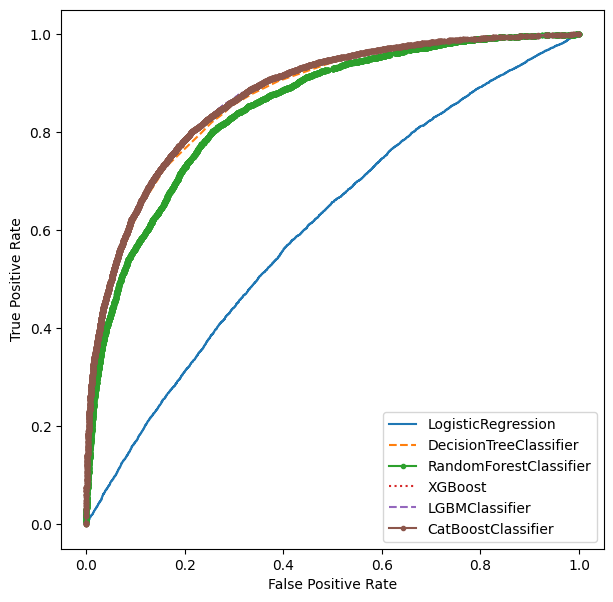

In [ ]:
# 차트 모양
plt.figure( figsize=(7,7))

# 반복
for al_nm, ( model, line_style ) in als.items(): # 알고리즘 이름, 알고리즘객체, 선의 모양
    #print( al_nm, line_style, model)
    # 학습
    model.fit( X_train, y_train ) # 학습수행-> 데이터를 경험했다
    # 예측 : [ F 예측확률, T 예측확률 ]
    pred = model.predict_proba( X_test ) # 학습에 사용하지 않은 데이터->한번도 접하지 않은..
    #print( pred )
    # T를 예측한 확률만(1로 판정한 확률만) 추출
    pred_t = pred[ :, -1]
    # 성능평가
    # roc_curve(실제정답, T를예측한확률점수)
    fpr, tpr, _ = roc_curve(y_test.values, pred_t, )
    # 차트그리기 - 플로팅
    plt.plot( fpr, tpr, line_style, label=al_nm)
    # 곡선하면적 계산 제공
    print( al_nm, auc(fpr, tpr))
    #break
    pass

# 데코
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# 화면출력
plt.show()

## ROC curve 시각화 함수

In [ ]:
from sklearn import metrics

# 각 모델의 accuracy, log_loss, auc를 print하는 함수
def print_results(classifier_name, y_test, y_pred, y_pred_proba, fpr, tpr):
    print('Train/Test split results:')
    print(classifier_name + " accuracy is %2.3f" % metrics.accuracy_score(y_test, y_pred))
    print(classifier_name + " log_loss is %2.3f" % metrics.log_loss(y_test, y_pred_proba))
    print(classifier_name + " auc is %2.3f" % metrics.auc(fpr, tpr))

# ROC curve 시각화 함수
def plot_roc_curve(fpr, tpr, classifier_name):
    idx = np.min(np.where(tpr > 0.95))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.7f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(classifier_name + ' ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

results = []
# 각 모델의 accuracy, log_loss 및 auc를 저장하는 함수
def save_accuracy(classifier_name, accuracy, log_loss, auc):
    results.append([classifier_name, accuracy, log_loss, auc])

# 차트
def plot_results():
    df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Log Loss', 'AUC'])
    df_results = df_results.sort_values(by=['Accuracy'], ascending=False)
    df_results = df_results.reset_index(drop=True)
    scaler = MinMaxScaler()
    df_results['Log Loss'] = scaler.fit_transform(df_results['Log Loss'].values.reshape(-1, 1))
    df_results.rename(columns={'Log Loss': 'Log Loss (Normalized)'}, inplace=True)
    df_results.head()
    df_results_sorted = df_results.sort_values(by='AUC')

    bar_width = 0.25
    pos = np.arange(len(df_results_sorted['Model']))
    plt.figure(figsize=(12, 6))
    plt.bar(pos, df_results_sorted['Accuracy'], color='steelblue', width=bar_width, label='Accuracy')
    plt.bar(pos + bar_width, df_results_sorted['Log Loss (Normalized)'], color='limegreen', width=bar_width, label='Log Loss (Normalized)')

    # AUC 그래프 표시
    plt.bar(pos + 2*bar_width, df_results_sorted['AUC'], color='orange', width=bar_width, label='AUC')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Performance')
    plt.xticks(pos + bar_width, df_results_sorted['Model'], rotation=90)
    plt.ylim(0, 1)
    plt.legend()

    for i, auc in enumerate(df_results_sorted['AUC']):
        plt.annotate(f'{auc:.7f}',
                    xy=(pos[i] + 2*bar_width, auc),
                    xytext=(5, 5),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    rotation=90)

    plt.tight_layout()
    plt.show()

### Logistic Regression

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "

Train/Test split results:
Logistic Regression accuracy is 0.790
Logistic Regression log_loss is 0.503
Logistic Regression auc is 0.605


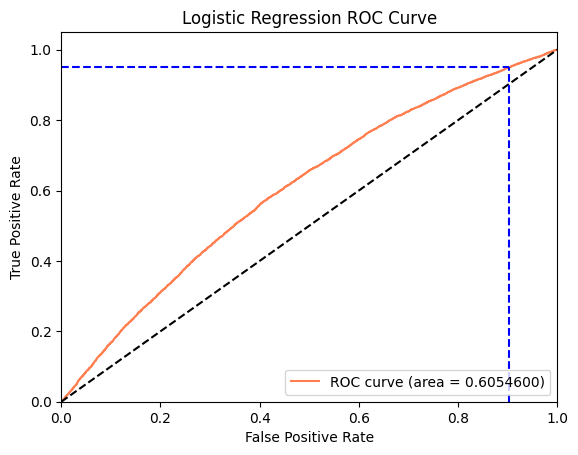

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Logistic Regression", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Logistic Regression")
save_accuracy("Logistic Regression", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

### Decision Tree

Train/Test split results:
Decision Tree accuracy is 0.786
Decision Tree log_loss is 7.692
Decision Tree auc is 0.684


/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')


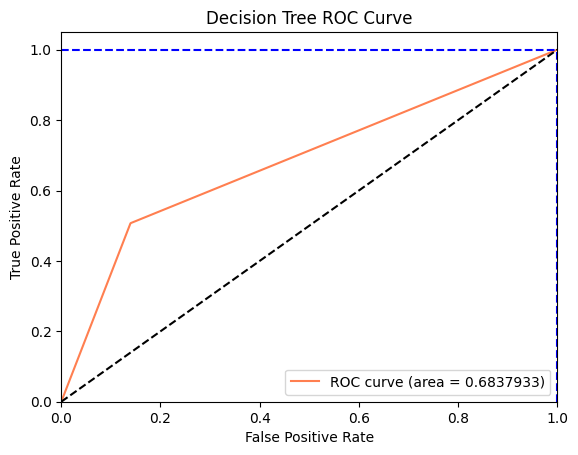

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Decision Tree", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Decision Tree")
save_accuracy("Decision Tree", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

### RandomForest

Train/Test split results:
Random Forest accuracy is 0.853
Random Forest log_loss is 0.354
Random Forest auc is 0.865


/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')


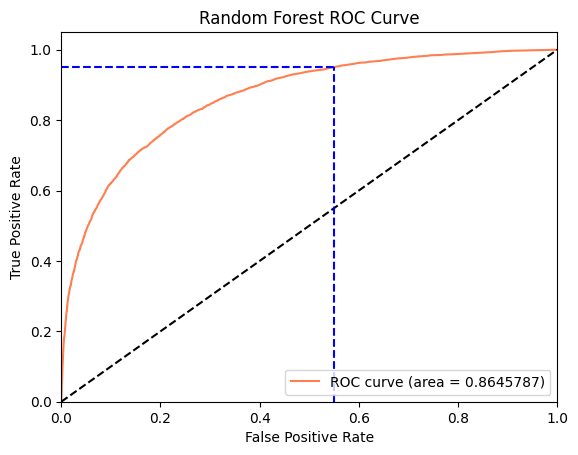

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Random Forest", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Random Forest")
save_accuracy("Random Forest", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

### XGBoost

Train/Test split results:
XGBoost accuracy is 0.854
XGBoost log_loss is 0.338
XGBoost auc is 0.874


/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')


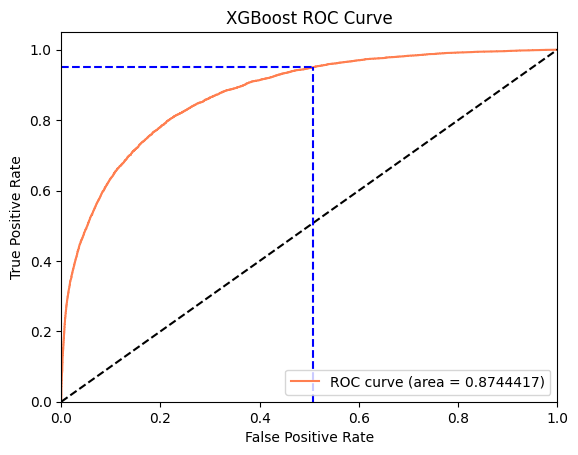

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("XGBoost", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "XGBoost")
save_accuracy("XGBoost", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

### LightGBM

[LightGBM] [Info] Number of positive: 28002, number of negative: 104025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212093 -> initscore=-1.312355
[LightGBM] [Info] Start training from score -1.312355
Train/Test split results:
LightGBM accuracy is 0.854
LightGBM log_loss is 0.336
LightGBM auc is 0.876


/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')


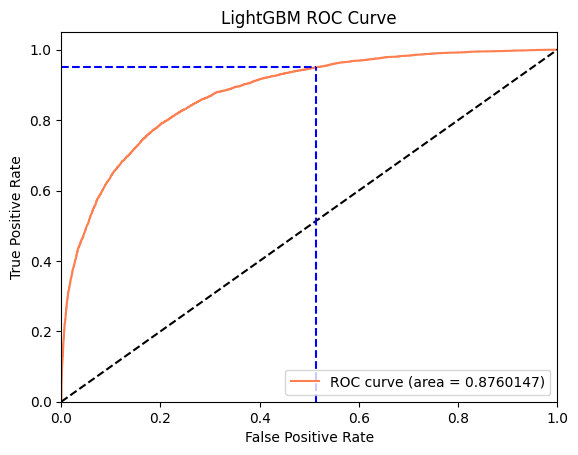

In [ ]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
y_pred_proba = lgb.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("LightGBM", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "LightGBM")
save_accuracy("LightGBM", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

### CatBoost

0:	total: 29ms	remaining: 1m 41s
1:	total: 45.7ms	remaining: 1m 19s
2:	total: 64.2ms	remaining: 1m 14s
3:	total: 82ms	remaining: 1m 11s
4:	total: 99.8ms	remaining: 1m 9s
5:	total: 117ms	remaining: 1m 8s
6:	total: 136ms	remaining: 1m 8s
7:	total: 151ms	remaining: 1m 6s
8:	total: 171ms	remaining: 1m 6s
9:	total: 188ms	remaining: 1m 5s
10:	total: 205ms	remaining: 1m 5s
11:	total: 223ms	remaining: 1m 4s
12:	total: 244ms	remaining: 1m 5s
13:	total: 261ms	remaining: 1m 4s
14:	total: 278ms	remaining: 1m 4s
15:	total: 294ms	remaining: 1m 3s
16:	total: 311ms	remaining: 1m 3s
17:	total: 328ms	remaining: 1m 3s
18:	total: 347ms	remaining: 1m 3s
19:	total: 366ms	remaining: 1m 3s
20:	total: 388ms	remaining: 1m 4s
21:	total: 406ms	remaining: 1m 4s
22:	total: 423ms	remaining: 1m 3s
23:	total: 441ms	remaining: 1m 3s
24:	total: 462ms	remaining: 1m 4s
25:	total: 477ms	remaining: 1m 3s
26:	total: 495ms	remaining: 1m 3s
27:	total: 512ms	remaining: 1m 3s
28:	total: 532ms	remaining: 1m 3s
29:	total: 548ms	re

/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
/var/folders/3d/bw13qgj53dl9xj8v2_d34mbr0000gn/T/ipykernel_1980/4246835873.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')


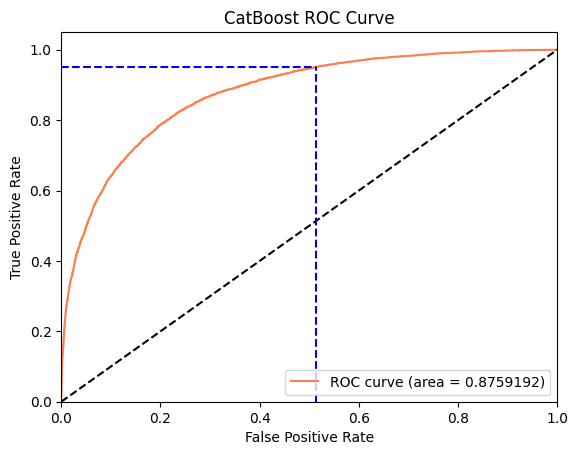

In [ ]:
cat = CatBoostClassifier(eval_metric = 'AUC',learning_rate = 0.0025, iterations= 3500)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
y_pred_proba = cat.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("CatBoost", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "CatBoost")
save_accuracy("CatBoost", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

# 성능 개선

## 피처엔지니어링 2

## 최적화

### 하이퍼파라미터 튜닝

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

params = {
    'n_estimators' : [100, 500 , 1000] , # 반복 횟수
    'max_depth' : [5 , 10] , # 최대 깊이
    'subsample' : [0.5, 1] # 서브샘플 비율
}

CPU times: user 45 µs, sys: 32 µs, total: 77 µs
Wall time: 116 µs


In [ ]:
# 그리드서치 객체 생성
gridsearch_lgbm_model = GridSearchCV(estimator=lgbm,
                                         param_grid=params,
                                         scoring='roc_auc', # 평가지표
                                         cv=5)
# 그리드서치 수행
gridsearch_lgbm_model.fit(X_train, y_train)

print('최적 하이퍼파라미터:', gridsearch_lgbm_model.best_params_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22401, number of negative: 83220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 105621, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212089 -> initscore=-1.312382
[LightGBM] [Info] Start training from score -1.312382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

# AutoML

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from pycaret.classification import *

X = pd.concat( [X_train, y_train], axis=1)

clf = setup(data      = X,  # 훈련데이터 => DataFrame으로 공급
            target    = 'Exited', # 정답컬럼명
            verbose   = True,     # 로그출력
            train_size= 0.9,      # 훈련:검증 비율이 9:1 => cv 수행
            data_split_shuffle=True, # 데이터를 세트로 나눌때 섞을지 여부
            session_id= 100,      # 난수시드
            normalize = True      # 정규화 처리 진행 -> 피처엔지니어링-피처인코딩 처리를 부여
            )

top_5_model = compare_models(fold=5, round=3, sort="Accuracy", n_select=5)

models()

,Description,Value
0,Session id,100
1,Target,Exited
2,Target type,Binary
3,Original data shape,"(132027, 10)"
4,Transformed data shape,"(132027, 10)"
5,Transformed train set shape,"(118824, 10)"
6,Transformed test set shape,"(13203, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.857,0.663,0.507,0.735,0.600,0.516,0.529,17.298
gbc,Gradient Boosting Classifier,0.856,0.876,0.497,0.739,0.594,0.510,0.525,39.304
catboost,CatBoost Classifier,0.856,0.647,0.506,0.734,0.599,0.515,0.528,55.586
xgboost,Extreme Gradient Boosting,0.855,0.628,0.508,0.725,0.597,0.512,0.524,43.604
rf,Random Forest Classifier,0.851,0.645,0.497,0.713,0.586,0.498,0.510,43.358
ada,Ada Boost Classifier,0.851,0.867,0.482,0.723,0.578,0.492,0.507,12.850
et,Extra Trees Classifier,0.849,0.656,0.487,0.709,0.577,0.489,0.502,27.376
knn,K Neighbors Classifier,0.835,0.624,0.496,0.643,0.560,0.460,0.466,24.936
qda,Quadratic Discriminant Analysis,0.830,0.840,0.400,0.667,0.500,0.406,0.425,1.350
lr,Logistic Regression,0.823,0.800,0.326,0.670,0.438,0.348,0.380,7.702


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### 오버피팅/언더피팅 방지

# 모델 적용 후 저장

In [ ]:
from sklearn.metrics import roc_auc_score

y_test_preds = gridsearch_lgbm_model.predict_proba(X_test)[:, 1]

# 검증 데이터 ROC AUC
roc_auc = roc_auc_score(y_test, y_test_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
검증 데이터 ROC AUC : 0.8765


In [ ]:
# 타깃값 1일 확률 예측
lgbm_tune = LGBMClassifier(n_estimators = 1000 ,max_depth = 10, subsample = 0.6, learning_rate = 0.01)
lgbm_tune.fit(X_train,y_train)
y_preds = lgbm_tune.predict_proba(test[features])[:, 1]

# 제출 데이터 수정
submission['Exited'] = y_preds

# 캐글에 제출할 파일 생성
submission.to_csv('ml_submission_v1_20240420.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 28002, number of negative: 104025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.486040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212093 -> initscore=-1.312355
[LightGBM] [Info] Start training from score -1.312355
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


# 결론